# Data Analysis with Visual Analytics

**Combining analytics with visualization**


## Overview

In this notebook we will continue to explore the Divvy bikes dataset using, cuDF, cuGraph, and cuSpatial to see how these analysis results can easily feed directly into visualization tools like hvplot and Datashader.

### cuDF, cuGraph, cuSpatial, hvplot, and Datashader
- [cuDF](https://docs.rapids.ai/api/cudf/stable/), is a GPU DataFrame library for manipulating data with a pandas-like API.

- [cuGraph](https://docs.rapids.ai/api/cugraph/stable/) will be utilized again, this time to compute PageRank on the trip graph. 

- [cuSpatial](https://docs.rapids.ai/api/cuspatial/stable/) is a collection of GPU accelerated algorithms for computing geo-spatial measures.

- [hvplot](https://hvplot.holoviz.org/) is a high-level plotting API for the PyData ecosystem built on [HoloViews](http://holoviews.org/).

- [Datashader](https://datashader.org/) is a library for high fidelity server side data rendering.

## Imports

In addition to the libraries mentioned above, we will also make use of libraries [cupy](https://docs.cupy.dev/en/stable/), [NumPy](https://numpy.org/), and [Pandas](https://pandas.pydata.org/) directly.

In [1]:
import cudf
import cugraph
import cupy
import cuspatial

import numpy as np
import pandas as pd

import datashader as ds
import datashader.transfer_functions as tf

import hvplot.cudf
import hvplot.pandas

from pathlib import Path


## Loading Data into cuDF

First let's load the data. In addition to the main Divvy `data.csv` file, we will also load the small `stations.csv` file that we prepared in the first notebook. 

In [4]:
DATA_DIR = Path("../data")

In [5]:
# Note: remeber to reparse into datetimes
df = cudf.read_csv(DATA_DIR / "data.csv", parse_dates=('starttime', 'stoptime'))

In [6]:
stations = pd.read_csv(DATA_DIR / "stations.csv")

We will want to continue our investigation into weekday vs weekend patterns, so let's first add a column for that:

In [7]:
df["weekday"] = df['starttime'].dt.weekday

## CuSpatial

Let's take a look at some spatial measures and see if there are any interesting features.

We might start with the first station, and see what the max trip length from it is.

In [8]:
r0 = df.iloc[0]
station_id, origin_lon, origin_lat = r0["from_station_id"], r0["longitude_start"], r0["latitude_start"]

The cuSpatial function `lonlat_to_cartesian` will let us quicly compute the x/y distances for every ending trip location. (Note that distances will in *kilometers*).

In [9]:
sub_df = df[df["from_station_id"]==station_id[0]]
dist = cuspatial.lonlat_to_cartesian(origin_lon[0], origin_lat[0], sub_df["longitude_end"], sub_df["latitude_end"])

CuPy functions can compute derived values on these GPU dataframes:

In [10]:
cupy.sqrt(cupy.max(dist.x**2 + dist.y**2))

array(11.37479459)

What if we want to compute this all trip distances? We can compute the distances using every station as a starting point:

In [11]:
def trip_dists(df):
    results = []

    for idx, row in stations.iterrows():
        station_id, origin_lon, origin_lat = int(row["station_id"]), row["lon"], row["lat"]
        sub_df = df[df["from_station_id"]==station_id]
        res = cuspatial.lonlat_to_cartesian(origin_lon, origin_lat, sub_df["longitude_end"], sub_df["latitude_end"])
        res["dist"] = cupy.sqrt(res.x**2 + res.y**2)
        results.append(res)
        
    return cudf.concat(results)

In [12]:
all_from_dists = trip_dists(df)

In [13]:
all_from_dists.hvplot.hist(y="dist", normed=True)

:Histogram   [dist]   (dist_frequency)

It might also be instesting to break the distribution of trips down weekday vs weekend

In [14]:
weekend_trips = df[df["weekday"].isin([5, 6])] # weekend days = 5, 6 
weekday_trips = df[df["weekday"].isin(list(range(5)))]  # weekday days = 0..4

In [15]:
weekend_dists = trip_dists(weekend_trips)
weekday_dists = trip_dists(weekday_trips)

In [16]:
all_combined_dists =  cudf.concat([weekday_dists, weekend_dists])
all_combined_dists.head()

x         y      dist
0  1.430482 -1.504416  2.075945
1 -0.287137 -2.174111  2.192990
2 -0.030118  0.914889  0.915385
3  0.132174 -0.797706  0.808582
4 -0.378072 -1.381667  1.432460

Plotting these two distributions together we can see the weekday (orange) trips peak more at shorter distances and the weekend distributions has more longer trips.

In [17]:
weekend_hist = weekend_dists.hvplot.hist(y="dist", alpha=0.3, bin_range=(0, 20), normed=True, color="blue")
weekday_hist = weekday_dists.hvplot.hist(y="dist", alpha=0.3, bin_range=(0, 20), normed=True, color="orange")
weekend_hist * weekday_hist

:Overlay
   .Histogram.I  :Histogram   [dist]   (dist_frequency)
   .Histogram.II :Histogram   [dist]   (dist_frequency)

## CuDF

Let's use CuDF direclty to group and aggregate our data to look for anyting intersting about the flow of trips in and out stations. 

We want to look at the daily net flow of trips at each station, i.e. how many more (or less) trips *started* at a station vs *ended* at a station in a given day.

In order to group by day, we first take the "floor" of each timestamp divided by one day

In [18]:
one_day = np.datetime64(1, 'D').astype('datetime64[ns]').astype('int64') 

df['from_day'] = df['starttime'].astype('int64') // one_day
df['to_day'] = df['stoptime'].astype('int64') // one_day

Now we can group by the station id and hour for both the departing and arriving cases. We name the columns from the size DataFrame `out` and `in` respectively:

In [19]:
df_out = df.groupby(by=["from_station_id", "from_day"]).size().to_frame('out').reset_index()
df_in = df.groupby(by=["to_station_id", "to_day"]).size().to_frame('in').reset_index()

Let's re name the columns to be the same in both DataFrames

In [20]:
df_out.rename(columns={"from_station_id": "station_id", "from_day": "day"}, inplace=True)
df_in.rename(columns={"to_station_id": "station_id", "to_day": "day"}, inplace=True)

And re-set the index to be the (station id, hour) pair

In [21]:
df_out = df_out.set_index(["station_id", "day"])
df_in = df_in.set_index(["station_id", "day"])

Now we can join these two DataFrames to compute an `flow = out - in` column

In [22]:
full_df = df_in.join(df_out, how="outer").fillna(0).reset_index()
full_df["flow"] = full_df["out"] - full_df["in"]

Let's also convert our "day" values back to proper timestamps:

In [23]:
full_df["time"] = (full_df["day"] * one_day).astype('datetime64[ns]')
full_df = full_df[["station_id", "time", "flow"]]

Now we can take a glimpse at the resulting DataFrame which has the net trip flow by station per day. A positive number means there was an excess of trips *starting* at station that day. A negative number indicates an excess of trips *ending* at a station that day.

In [24]:
full_df.head()

station_id       time  flow
0           2 2015-05-08     1
1           2 2015-05-20     1
2           2 2015-10-20     4
3           2 2015-10-23     1
4           2 2015-10-30     1

We might like to look at the maximal behaviour. What is a high number of excess arrivals or departures at a station? Let's pull out individual timeseries for each station id, and look a the max/min for each station:

In [25]:
flows = []
for i in stations.station_id:
    subdf = full_df[full_df.station_id==i].drop("station_id").set_index("time")
    flows.append((i, subdf.flow.max(), subdf.flow.min()))
flows = pd.DataFrame(flows, columns=["station_id", "max_out", "max_in"])

In [26]:
flows

station_id  max_out  max_in
0             2       24     -10
1             3       21     -32
2             4       23     -18
3             5       16     -18
4             6       20     -22
..          ...      ...     ...
581         622        7      -9
582         623       27     -11
583         624       17      -4
584         625        6      -4
585         626        2      -2

[586 rows x 3 columns]

With this information, we can see what stations had the larges ever excess departures (station 192) or arrivals (station 77):

In [27]:
flows.iloc[flows.max_out.argmax()]

station_id    192
max_out       163
max_in        -87
Name: 173, dtype: int64

In [28]:
flows.iloc[flows.max_in.argmin()]

station_id     77
max_out        90
max_in       -111
Name: 69, dtype: int64

Knowing about execess arrivals vs departures is probably import for Divvy to be able to manually re-allocate bikes. We could ask what fraction of stations ever have a max of more than 30 excess trips:

In [29]:
len(flows[flows.max_out > 30])

73

In [30]:
len(flows[flows.max_in < -30])

52

We would try to look at all of these trip flow series for each station at once, using Datashader. First we need to prepare a new Dataframe that has all the series as columns:

In [31]:
series = []

for i in stations.station_id:
    s = full_df[full_df.station_id==i][["time", "flow"]]
    s.rename(columns={"flow": f"s{i}"}, inplace=True)
    s = s.set_index("time")
    series.append(s)
    
df_wide = cudf.concat(series, axis=1).fillna(0)

The resulting Dataframe has a time series for every column, one for each station:

In [32]:
df_wide

s2  s3  s4  s5  s6  s7  s9  s11  s12  s13  ...  s616  s617  s618  \
time                                                   ...                     
2014-01-01   0   0   0  -1   0   0   0    0    0   -1  ...     0     0     0   
2014-01-02   0   0   0   0   0   0   0    0    0    0  ...     0     0     0   
2014-01-03   0   0   0   0   0   0   0    0    0    0  ...     0     0     0   
2014-01-04   0   0   0   0   0   0   0    0    0    0  ...     0     0     0   
2014-01-05   0   0   0   0   0   0   0    0    0    0  ...     0     0     0   
...         ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...   ...   ...   ...   
2017-12-28   0   3   0  -1   0   0   1    0    0    1  ...     0     0     0   
2017-12-29   0  -2   1  -1   2   0   0   -1    0    1  ...     0     0     0   
2017-12-30   0   0   0   0   0  -1   0    0    0   -1  ...     0     0     0   
2017-12-31   0   0  -1  -2   0   1   0    0    0    1  ...     0     0     0   
2018-01-01   0   0   0   0   0   0   0    0    0    0  ...     0     0     0   

            s619  s620  s622  s623  s624  s625  s626  
time                                                  
2014-01-01     0     0     0     0     0     0     0  
2014-01-02     0     0     0     0     0     0     0  
2014-01-03     0     0     0     0     0     0     0  
2014-01-04     0     0     0     0     0     0     0  
2014-01-05     0     0     0     0     0     0     0  
...          ...   ...   ...   ...   ...   ...   ...  
2017-12-28     1    -2     1     2     0     0    -2  
2017-12-29     0    -1     1    -1    -2     0     1  
2017-12-30     0     1     1    -1     0     0     2  
2017-12-31     0    -2    -1     0     1     0    -1  
2018-01-01     0     0     0     0     0     0     0  

[1460 rows x 586 columns]

It's simple to pull out individual stations for comparison using `hvplot`:

In [33]:
df_wide.hvplot(y=["s81", "s287"], alpha=0.3)

:NdOverlay   [Variable]
   :Curve   [time]   (value)

Lastly, lets take a look at the data with datashader. First we make a funtion `series_shade` that can take a wide dataframe of timeseries like we make above, and render *all* of the series at once using datashaher:

In [69]:
def series_shade(df):
    cols = list(df.columns)
    
    itime = cudf.to_datetime(df.index).astype('int64')
    x_range = (itime[0], itime[-1])
    
    y_range = (df.min().min(), df.max().max())
    
    temp = cudf.DataFrame(df)
    temp["itime"] = itime
    
    cvs = ds.Canvas(plot_height=400, plot_width=1460)
    agg = cvs.line(temp, x="itime", y=cols, agg=ds.count(), axis=1)
    
    print(f"y range: ({y_range[0]}, {y_range[1]})")
    return tf.shade(agg, how='eq_hist')

Now let's pass in out daily net excess data to get a rough datashder plot:

y range: (-111, 163)


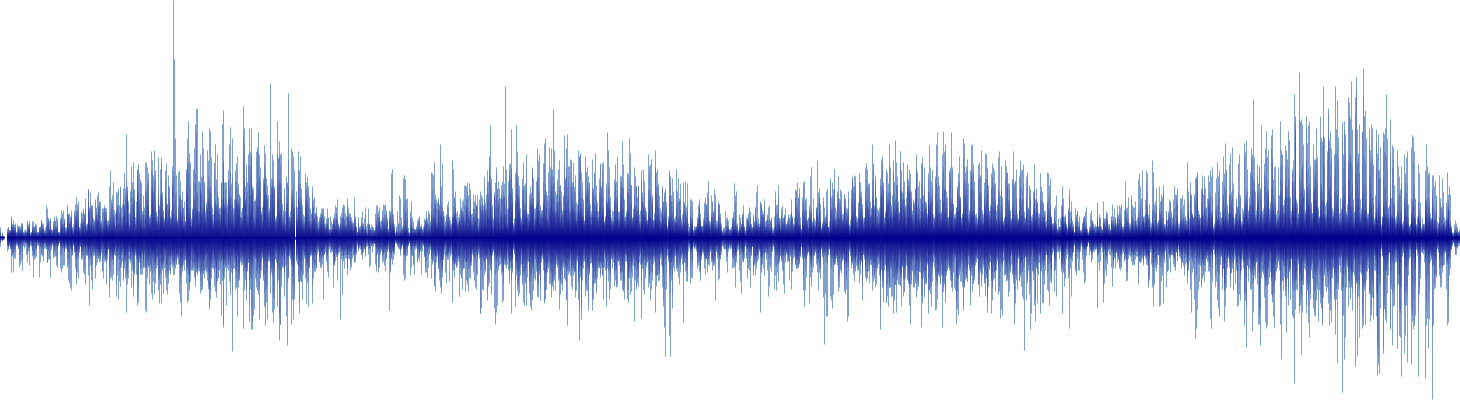

In [70]:
series_shade(df_wide)

It's not completely clear what we can see here but it points to some ideas for future exporation. 

As a last experiment, let's make the same plot, but with *cumulative* excess trips:

In [71]:
df_cumulative = df_wide.cumsum()

y range: (-12958, 32486)


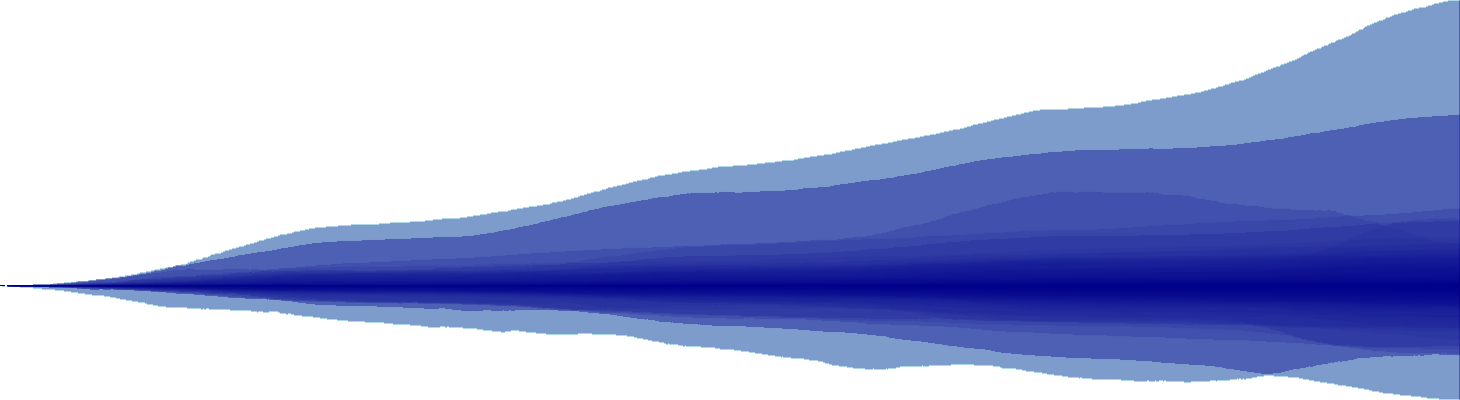

In [72]:
series_shade(df_cumulative)

This a bit more interesting and points to the notion that Divvy must be engaging in a lot of continual re-allocation of its bikes to offset these excess trips. 

## Pagerank

Now we will use the `cugraph.pagerank` function to see if there are patterns for the "most popular" stations.

### Single hour 

First, let's see what it looks like to compute page range for a single hour of the day, e.g. 5PM. First subset the data to only look at data for trips starting at that hour:

In [38]:
d17 = df[df["hour"]==17]

Next group by (from_station_id, to_station_id) and then take the group size to get all the unique indivual routes between stations that hour, and also the number of trips that took each of those routes:/

In [39]:
g17 = df.groupby(by=["from_station_id", "to_station_id"])
routes17 = g17.size().reset_index()
routes17.head()

from_station_id  to_station_id    0
0                2              2  260
1                2              3  156
2                2              4  161
3                2              5   32
4                2              6  123

Now we can create a `cugraph.Graph` 

In [40]:
G = cugraph.Graph()

In [41]:
G.from_cudf_edgelist(d17, source='from_station_id', destination='to_station_id')

In [42]:
d17_page = cugraph.pagerank(G)
d17_page.head()

pagerank  vertex
0  0.001222     484
1  0.001126     485
2  0.001513     486
3  0.001412     487
4  0.000710     488

Now that we have computed pagerank on the network of trips, let's see which stations rank as most important at 5PM (on any day)

In [43]:
d17_top = d17_page.nlargest(10, "pagerank").to_pandas()
d17_top.head()

pagerank  vertex
77   0.003312      81
563  0.003293     192
270  0.003217     287
483  0.003138     174
75   0.003132      77

Plotting these stations we can see that at 5PM the most important stations are all downtown:

In [44]:
d17_page_locs = stations[stations.station_id.isin(d17_top.vertex)]
d17_page_locs.hvplot.points(x='lon', y='lat', size=300, geo=True, tiles="OSM").opts(width=800, height=800)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]

Now let's look at how stations rank week on weekdays vs weekends. The code below computes the pagerank broken out by individual day of the week.

In [45]:
results = {}
for w in range(7):
    dfw = df[df["weekday"]==w]
    G = cugraph.Graph()
    G.from_cudf_edgelist(dfw, source='from_station_id', destination='to_station_id')
    df_page = cugraph.pagerank(G).nlargest(20, "pagerank")
    results[w] = set(df_page.to_pandas()["vertex"])

Now let's find out what stations were highest ranked among all weekdays and weekend days

In [46]:
weekday = set.intersection(*[results[i] for i in range(5)]) # days 1..5 are weekdays
weekend = set.intersection(results[5], results[6])  # days 5 and 6 are the weekend

Now we can see the stations that are all import on weekdays, and all important on weekends (and that there is not much overlap):

In [47]:
weekend

{29, 35, 56, 61, 69, 76, 128, 130, 176, 183, 198, 210, 219, 268, 331}

In [48]:
weekday

{37, 49, 69, 75, 77, 81, 91, 174, 192, 283, 287}

Finally we can plot these quickly using `hvplot`. Let's add a column to denote weekday/weekend so that we can group by that

In [49]:
r1 = stations[stations.station_id.isin(weekend)]
r1 = r1.assign(type="Weekend")

r2 = stations[stations.station_id.isin(weekday)]
r2 = r2.assign(type="Weekday")

result = pd.concat([r1, r2])

Looking at the plot, nearly all the important weekday stations are downtown, and on the weekend the important stations are furhter out, in popular districts around downtown:

In [50]:
result.hvplot.points(x='lon', y='lat', by='type', 
                     alpha=0.5, size=485, geo=True, tiles="OSM").opts(width=800, height=800)

:Overlay
   .Tiles.I     :Tiles   [x,y]
   .NdOverlay.I :NdOverlay   [type]
      :Points   [lon,lat]

We can note that the important weekday stations (for all hours) are similarly clustered downtown as the top rush-hour stations at 5pm.

What looking at our previous trip flow data with respect to weekday vs weekend? 

In [51]:
flows[flows.station_id.isin(weekday)]

station_id  max_out  max_in
33           37       48     -70
45           49       57     -81
62           69       35     -30
67           75       50     -34
69           77       90    -111
71           81       80     -94
79           91       75     -78
157         174      106     -81
173         192      163     -87
260         283       70     -44
264         287      110     -67

In [52]:
flows[flows.station_id.isin(weekday)]

station_id  max_out  max_in
33           37       48     -70
45           49       57     -81
62           69       35     -30
67           75       50     -34
69           77       90    -111
71           81       80     -94
79           91       75     -78
157         174      106     -81
173         192      163     -87
260         283       70     -44
264         287      110     -67

E.g. we can look at all the weekday stations where we can see some stations are consistent in having more excess departures or arrivals:

In [53]:
df_wide.hvplot(y=[f"s{n}" for n in weekday], alpha=0.2)

:NdOverlay   [Variable]
   :Curve   [time]   (value)

We can also look at the weekend stations. Here there is one station with a clear excess of arrivals. 

In [54]:
df_wide.hvplot(y=[f"s{n}" for n in weekend], alpha=0.2)

:NdOverlay   [Variable]
   :Curve   [time]   (value)

Hovering over the plot we can see that it is station 268 which turns out to be right by the waterfont museum district:

In [55]:
df[df["to_station_id"]==268].iloc[0]

trip_id  year  month  week  day  hour    usertype gender  \
590  2353857  2014      6    27    0    18  Subscriber   Male   

              starttime            stoptime  ...  longitude_start  \
590 2014-06-30 18:16:00 2014-06-30 18:26:00  ...        -87.63625   

     dpcapacity_start  to_station_id             to_station_name latitude_end  \
590              15.0            268  Lake Shore Dr & North Blvd    41.911722   

     longitude_end  dpcapacity_end  weekday  from_day   to_day  
590     -87.626804            15.0        0   16251.0  16251.0  

[1 rows x 26 columns]

## Summary of interesting analytics results 
Does not have to be significant but noteable